<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Andrea Flores Fernández y Tania Bell Nicholls.

**Fecha:** 09 de octubre del 2021.

**Expediente** : IF725449 y IF716767.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Tania-Bell/Proyecto_TBell_AFlores.git

# Proyecto Simulación - Censo de Ingresos

## Descripción

> En este proyecto utilizaremos datos reales de un censo realizado en 1994. Los datos fueron extraídos por Barry Becker y Ronny Kohavi y el censo fue realizado en EEUU. Los datos consisten en información de personas adultas y tiene 14 variables como el nivel de educación, edad, género, ocupación, estado civil, etc. Hay datos sobre más de 48 mil personas. 

## Objetivos

> #### Objetivo General:
El objetivo de este proyecto es ver si hay una distribución de probabilidad dentro de los datos del censo realizado. Con esta información se pretende discernir si hay alguna tendencia en la información demográfica de las personas.

> #### Objetivo específico:
    > - Organizar y limpiar los datos proporcionados.
    > - Realizar la correlación entre los diferentes factores proporcionados en la base de datos con el ingreso de las personas.
    > - Incluso se puede analizar la influencia de la edad en los ingresos de las personas.
    > - Realizar una simulación para determinar las condiciones que llevan a un ingreso mayor a $50,000.

## Definición del Problema

>El ingreso de las personas es un factor que determina su estilo de vida. Sin importar el punto de vista sobre el aspecto económico y el capitalismo, la realidad es que en el mundo en el que vivimos, el dinero es muy importante ya que determinará en dónde vives, que comes, que haces, la familia que puedes tener, etc. A través de los datos proporcionados por el censo, queremos analizar si hay alguna correlación entre los aspectos de la vida de las personas y su ingreso. De esta manera, podremos saber si hay una manera de incrementar los ingresos obtenidos. 

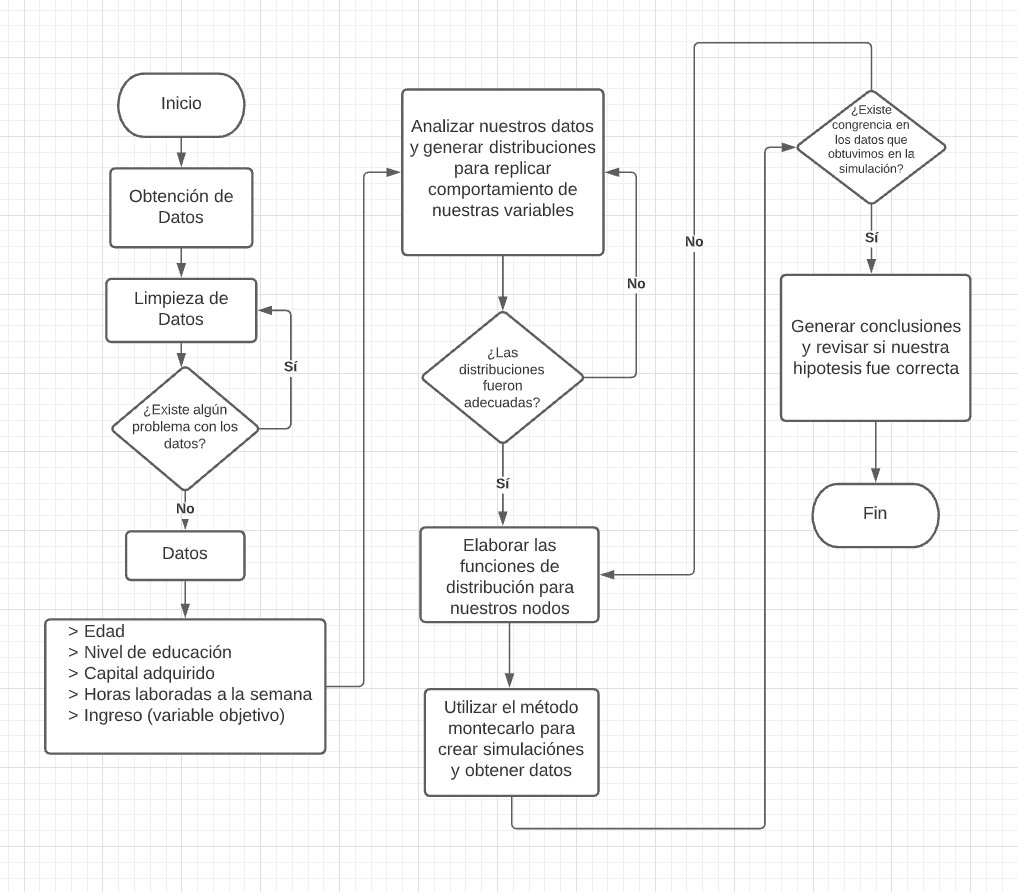

## Nodos y variables que se decidieron simular y por qué

>Para desarrollar el proyecto tomamos las siguientes variables:
    > - Edad
    > - Nivel de educación
    > - Capital adquirido
    > - Horas laboradas a la semana

>De estas todas las variables que nos proporciona el dataset, filtramos las que no son numéricas y en la matriz de correlación que se realizó, se definieron las que más afectaban al ingreso.

## Definición de hipótesis y supuestos

>Los supuestos que se dan por verdadero en nuestro proyecto son los siguientes:
    > - Las variables sólo son de personas adultas.
    > - Las variables que se analizarán son suficientes para analizar las distribuciones en la edad, nivel de educación, capital adquirido y las horas laboradas a la semana.

>Nuestra hipótesis es que podremos encontrar distribuciones adecuadas para la edad y las horas pero no para el nivel de educación y el capital adquirido.

## Obtención de bases de datos

> Los datos se obtuvieron de una plataforma de diferentes bases de datos llamada UCI Machine Learning Repository. La base de datos seleccionada es del censo realizado en EEUU del año 1994.

In [1]:
# importación de las librerías
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm 
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importación de los datos, el archivo está en un csv y se llama adult
data = pd.read_csv('adult.csv')
data = data[['age','educational-num','capital-gain','hours-per-week']].head(20001)
data

,age,educational-num,capital-gain,hours-per-week
0,25,7,0,40
1,38,9,0,50
2,28,12,0,40
3,44,10,7688,40
4,18,10,0,30
...,...,...,...,...
19996,21,10,0,20
19997,44,13,0,50
19998,29,13,0,40
19999,19,10,0,22


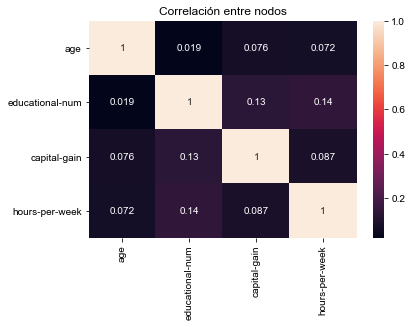

In [3]:
# análisis de correlación entre los datos
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True, linewidths=.0001)
sn.set(rc = {'figure.figsize':(5,5)})
plt.title('Correlación entre nodos') # generación de tabla
plt.show()

En la matriz de correlación superior podemos analizar que se ve una correlación notoria o significativa entre nuestras varibles. Podemos descartar la relación entre la edad, nivel de educación, capital adquirido o las horas laboradas por semana.

## Visualización de Variables

Para generar una idea general de nuestros datos, los visualizaremos usando histogramas. Nos mostrará, a primera vista, si hay una distribución obvia en nuestros nodos.

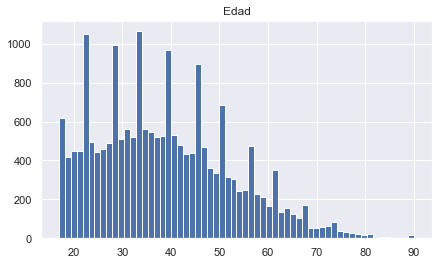

In [4]:
# histograma con 60 bins para visualizar la variable edad
plt.figure(figsize=(7,4))
plt.hist(data['age'], bins = 60);
plt.title('Edad');

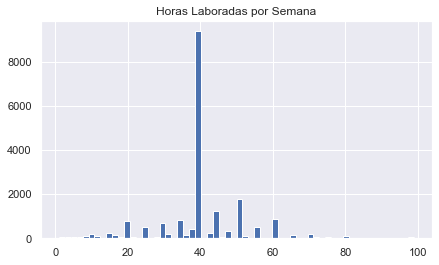

In [5]:
# histograma con 60 bins para visualizar la variable horas laboradas por semana
plt.figure(figsize=(7,4))
plt.hist(data['hours-per-week'], bins = 60);
plt.title('Horas Laboradas por Semana');

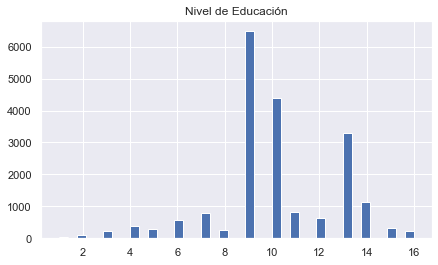

In [6]:
# histograma con 40 bins para visualizar la variable nivel de educación
plt.figure(figsize=(7,4))
plt.hist(data['educational-num'], bins = 40);
plt.title('Nivel de Educación');

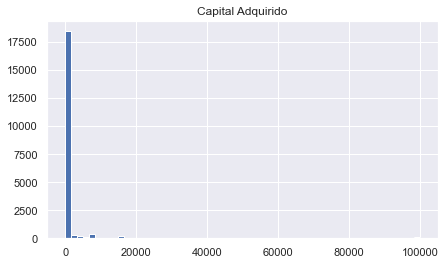

In [7]:
# histograma con 60 bins para visualizar la variable capital adquirido
plt.figure(figsize=(7,4))
plt.hist(data['capital-gain'], bins = 60);
plt.title('Capital Adquirido');

Como se puede analizar en los histogramas anteriores, no tenemos una distribución clara. El primer paso que tenermos que hacer es ajustar la información para que se pueda analizar de una forma más fácil y amena. La única que pudieramos decir que sí tiene una distribución más notoria es la de la edad. Esto lo pudimos predecir desde el principio ya que la edad, independientemente de qué grupo de personas se está analizado, tiene una distribución normal.

## Funciones

In [19]:
def kde_sklearn(x:'X, nodo', x_grid:'generación de números en intervalo', bandwidth:'bandwidth óptimo', **kwargs:'especificaciones'):
    '''
    Kernel Density Estimation with Scikit-learn
    '''
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


def distribuciones(data:'Nodo'):
    '''
    Iteración con las diferentes distribuciones. Retorna el plot con las distribuciones y tabla de error
    '''
    #generación de iteración de distribuciones en st, sólo las continuas
    rv_continuas = [d_i for d_i in dir(st) if isinstance(getattr(st, d_i), getattr(st, 'rv_continuous'))]

    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    #crea la tabla de errores por ditribución iterada
    error = pd.DataFrame(columns=['Distribución', 'Error'])
    i = 0
    y, x, _ = ax.hist(data, bins=50, density=True)
    x = x[1:]
    #se ejecuta la iteración
    for d_i in rv_continuas[20:30] + ['beta']:
        try:
            params = getattr(st, d_i).fit(data)
            data_hat = getattr(st, d_i).pdf(x, *params) # usando probability distribution function
            ax.plot(x, data_hat, label=d_i)
            error.loc[i, :] = [d_i, np.mean((y - data_hat)**2)]
            i += 1
        except ValueError:
            pass

    plt.legend()
    #error.set_index('distribucion', inplace=True)
    #error.sort_values('error', inplace=True)
    return error

def pruebaq_q(data:'Nodo', dist:'Distribución óptima'):
    '''
    Prueba Q_Q, genera gráfica con la distribución y la gráfica Q_Q (45 grados)
    '''
    # Histograma de las variables creadas
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    fig.tight_layout(pad=3.0)
    # distribuciones y prueba
    y, x, _ = ax[0].hist(data, 50, density=True, label='Histograma')
    params = getattr(st, dist).fit(data)
    y_hat = getattr(st, dist).pdf(x, *params) # usando probability distribution function
    # creación de gráficas
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probabilidad')
    ax[0].grid()
    grafica = st.probplot(data, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
    ax[1].grid()
    ax[1].set_title('Scipy')
    plt.show()
    
def red_var(data:'Nodo', f:'Pdf', t:'Función lambda', model:'Model'):
    '''
    Reducción de Varianza, retorna las variables aceptadas
    '''
    # parámetros y generación de variables
    r1 = muestra_est(1000*5) # usando función del muestreo estratificado
    np.random.shuffle(r1)
    ct = 0
    i = 0
    var_acept = np.zeros(1000)
    # iteración de aceptación o rechazo
    while ct < 1000:    
        r = np.random.uniform(min(data), max(data), 1)
        f_x = f(r, model)
        t_x = t(r)
        condition = r1[i] * t_x <= f_x
        if condition[0]:
            var_acept[ct] = r[0]
            ct += 1
        i+=1
    return var_acept

def pdf(x:'x_grid, intervalo', model:'Model'):
    '''
    Pdf para reducción de varianza
    '''
    return np.exp(model.score_samples(x.reshape(-1, 1)))

def muestra_est(n:'Número de muestras'):
    '''
    Muestreo Estratificado
    '''
    # generación de variables aleatorias entre 0 y 1
    u = np.random.uniform(0, 1, n)
    i = np.arange(0, n)
    return (u + i) / n

def kolmogorov(data:'Nodo',dist:'Distribución Óptima'):
    '''
    Prueba Kolmogorov-Smirnov
    '''
    param = getattr(st, dist).fit(data)
    return st.kstest(data, dist, args = (param))

def chi_cuadrada(dist:'Distribución Óptima', data:'Nodo', x:'x', y:'y', J1:'Bins', c:'Confianza'):
    '''
    Prueba de Chi cuadrada, genera el teórico, el de la librería, el estadístico y arroja media y desviación estándar
    '''
    # parámetros
    param = getattr(st, dist).fit(data)
    pi = getattr(st, dist).pdf(x, *param) # usando probability distribution function
    
    Ei = x*pi

    x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y))) # teórico
    print('Chi cuadrado teórico: ', x2)

    X2 = st.chisquare(y, Ei) # usando librería scipy.stats
    print('Chi cuadrado stats: ', X2)

    p = len(param) 
    m = J1-p-1 
    
    Chi_est = st.chi2.ppf(q=c, df=m) # estadístico
    print('Estadístico de chi_cuadrado: ', Chi_est)
    
    mu = np.mean(x) # media
    sigma = np.std(x) # desviación estándar
    print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

## Procedimiento de la simulación:

>Primero, generaremos box-plots para visualizar los outliers y poderlos eliminar para tener datos más uniformes. Luego, implementaremos algunos métodos como logaritmo o raíz cuadrada para ajustar los datos. Como tercer paso, encontraremos el bandwidth adecuado para cada nodo y posteriormente realizaremos el método de KDE usando la librería Scikit-learn. Después realizaremos el método de reducción de varianza usando aceptación y rechazo. Luego simularemos con varias distribuciones para ver cuál es la más adecuada para cada nodo. Usando la distribución con menor error, realizaremos la prueba Q_Q, kolmogorov y chi cuadrada. 

## Nodo 1: Edad

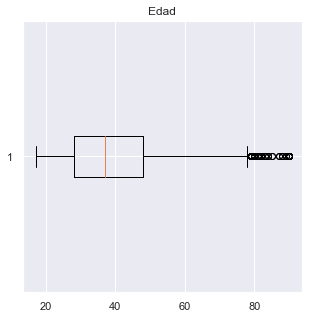

In [9]:
edad = np.array(data['age'])
plt.boxplot(edad,vert=False)
plt.title('Edad')
plt.show() #mostramos boxplot e identificamos outliers 

In [10]:
edad = np.log(edad[edad>0])
edad = edad[~np.isnan(edad)]
edad #aplicamos una transformación logartmica para ver si mejora la distribución de nuestros datos 

array([3.21887582, 3.63758616, 3.33220451, ..., 3.36729583, 2.94443898,
       3.04452244])

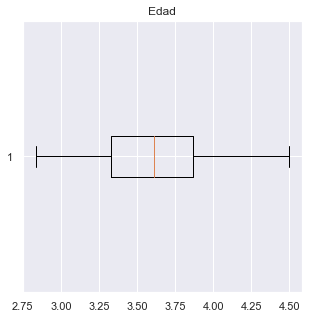

In [11]:
plt.boxplot(edad,vert=False)
plt.title('Edad')
plt.show() # se muestra una mejor distribución 

In [12]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)},
                    cv=15) # 15-fold cross-validation
grid.fit(edad[:, None])


GridSearchCV(cv=15, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])})

In [13]:
print(grid.best_params_) # usando KDE encontramos un bandwith para el mejor ajuste de nuestros datos 

{'bandwidth': 0.07142857142857142}


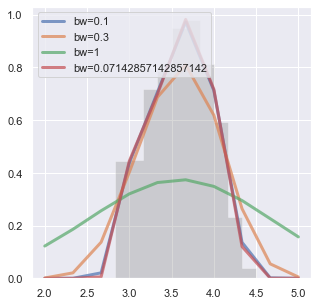

In [14]:
fig, ax = plt.subplots() 
for bandwidth in [0.1, 0.3, 1, 0.07142857142857142]:
    ax.plot(np.linspace(2,5,10), kde_sklearn(edad, np.linspace(2,5,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(edad, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left') # vemos en el grafico el ajuste de los datos usando diferentes bw y vemos como funciona el que nos arrojo 

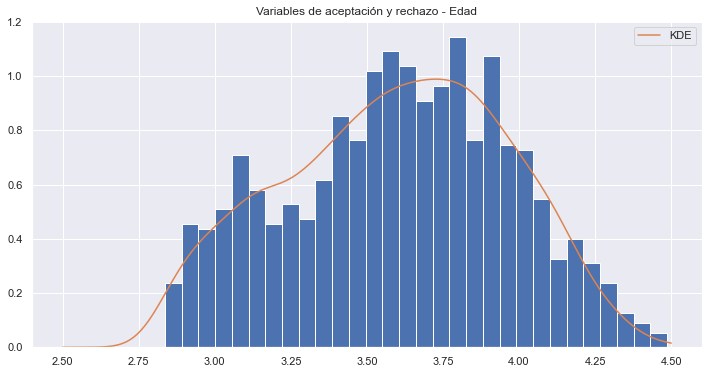

In [15]:
model = KernelDensity(bandwidth=0.07142857142857142) 
model.fit(edad.reshape(-1, 1))
x_grid = np.linspace(2.5, 4.5, 1000)
pdf_edad = pdf(x_grid[:, None], model)

plt.figure(figsize=(12,6))
var_aleatorias = red_var(edad,pdf, lambda x: max(pdf_edad) * np.ones(len(x)), model)

plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_edad, alpha=1, label='KDE')
plt.title('Variables de aceptación y rechazo - Edad')
plt.legend()
plt.show()

,Distribución,Error
0,exponweib,0.068328
1,f,0.081234
2,fatiguelife,0.081385
3,fisk,0.087554
4,foldcauchy,0.107659
5,foldnorm,0.076885
6,gamma,0.08303
7,gausshyper,0.073924
8,genexpon,0.103273
9,genextreme,0.07404


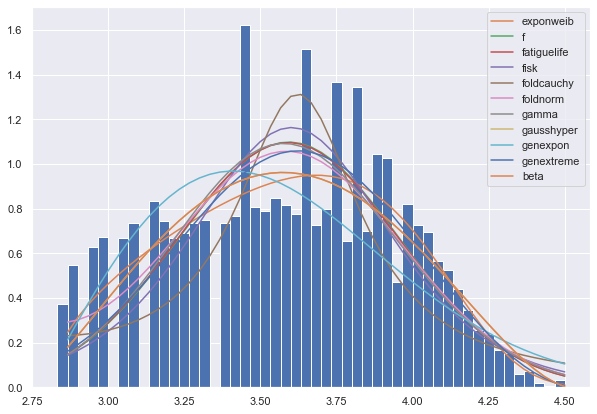

In [20]:
distribuciones(edad) # la mejor distribución fue exponweib para nuestros datos 

Exponweib

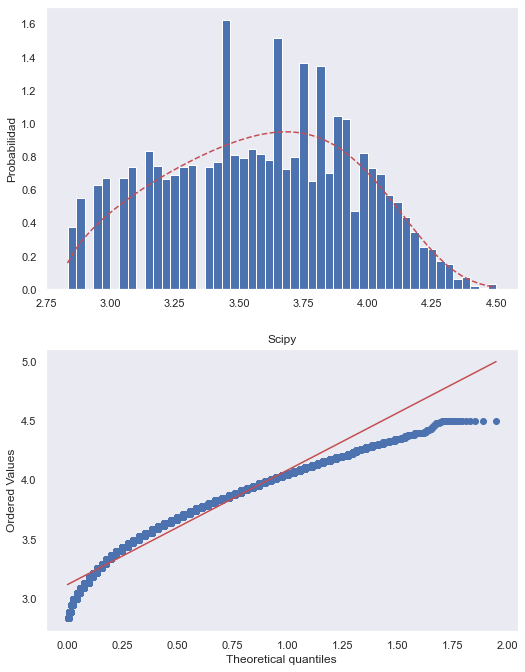

In [21]:
pruebaq_q(edad,'exponweib') # llama la función para hacer la prueba de 45 grados 

In [22]:
kolmogorov(edad,'exponweib') # hacemos prueba de kolmogrov 

KstestResult(statistic=0.036776255825216375, pvalue=6.126145798604598e-24)

Chi cuadrado teórico:  33.446314234070286
Chi cuadrado stats:  Power_divergenceResult(statistic=33.446314234070286, pvalue=0.2601046014522166)
Estadístico de chi_cuadrado:  37.65248413348277
Media muestral =  3.6942881126311415 
Desviación estándar muestral =  0.480837564006074


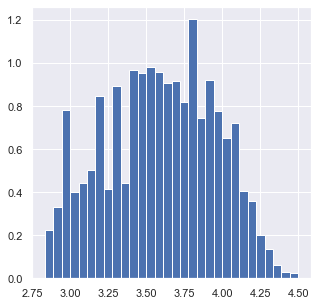

In [23]:
J1 = 30
y, x, _ = plt.hist(edad, bins = J1, density = True)
x = x[1:]
chi_cuadrada('exponweib',edad,x,y,J1,0.95) # aplicamos la prueba de chi cuadrada 

## Nodo 2: Horas de trabajo a la semana

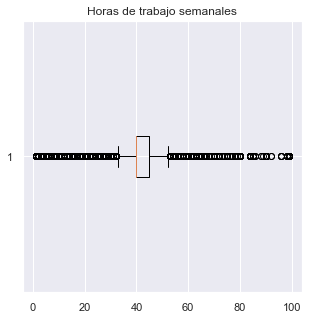

In [24]:
horas = np.array(data['hours-per-week'])
plt.boxplot(horas,vert=False)
plt.title('Horas de trabajo semanales')
plt.show() # sacamos boxplor para ver la disribución de nuestros datos

In [25]:
horas = np.sqrt(horas[horas>0])
horas = horas[~np.isnan(horas)]
horas # aplicamos una transformación de raiz cuadrada para mejorar la distribución de nuestros datos

array([6.32455532, 7.07106781, 6.32455532, ..., 6.32455532, 4.69041576,
       6.32455532])

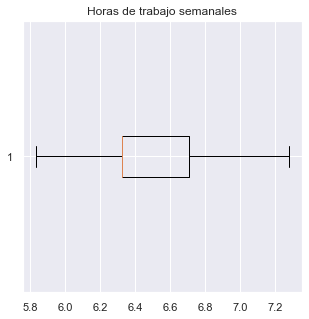

In [26]:
plt.boxplot(horas,vert=False,  showfliers=False)
plt.title('Horas de trabajo semanales')
plt.show() # usamos showfliers para eliminar los outliers ya que la transformación no fue suficiente 

In [27]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)},
                    cv=15) # 15-fold cross-validation
grid.fit(horas[:, None]) 

GridSearchCV(cv=15, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])})

In [28]:
print(grid.best_params_) #encontramos el bw ideal para el KDE 

{'bandwidth': 0.07142857142857142}


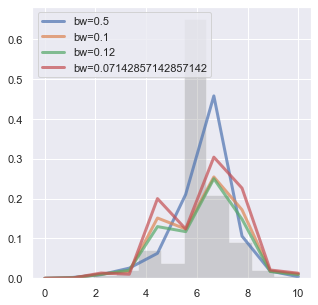

In [29]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.07142857142857142]:
    ax.plot(np.linspace(0,10,10), kde_sklearn(horas, np.linspace(0,10,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(horas, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left') #vemos como se ajustan a nuestro datos 

,Distribución,Error
0,exponweib,0.120844
1,f,0.115558
2,fatiguelife,0.115525
3,fisk,0.108345
4,foldcauchy,0.042303
5,foldnorm,0.11555
6,gamma,0.116918
7,gausshyper,0.116674
8,genexpon,0.137287
9,genextreme,0.118773


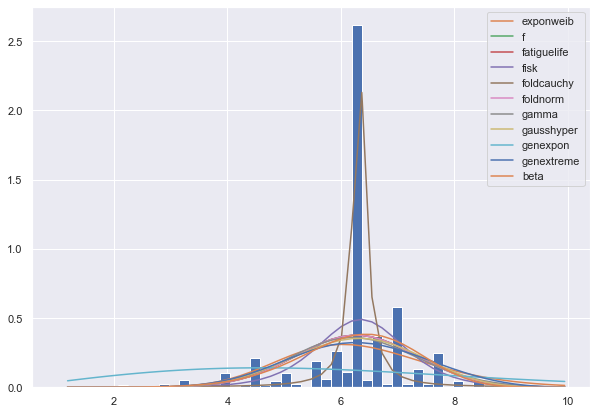

In [30]:
distribuciones(horas)

Foldcauchy

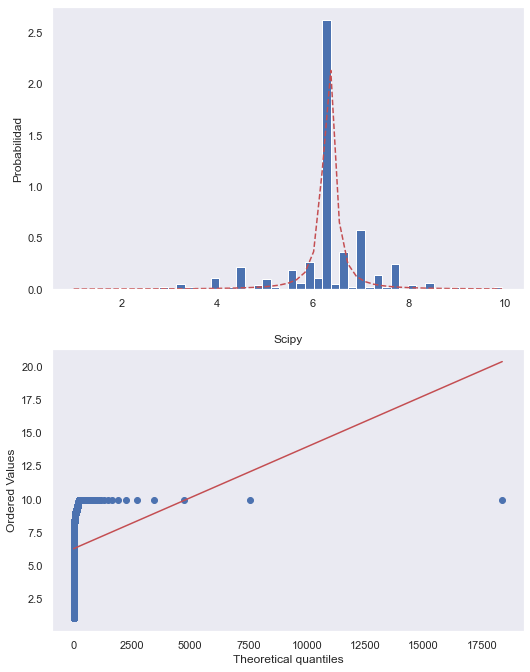

In [38]:
pruebaq_q(horas,'foldcauchy') # a pesar de la funcion de distribución recomienda expoinweb probando con otras la mejor se ajusto fue foldcauchy 

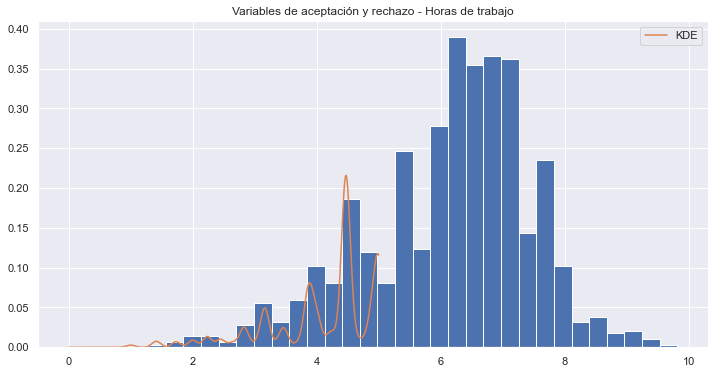

In [32]:
model = KernelDensity(bandwidth=0.07142857142857142)
model.fit(horas.reshape(-1, 1))
x_grid = np.linspace(0, 5, 1000)
pdf_horas = pdf(x_grid[:, None], model)

plt.figure(figsize=(12,6))
var_aleatorias = red_var(horas,pdf, lambda x: max(pdf_horas) * np.ones(len(x)), model)

plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_horas, alpha=1, label='KDE')
plt.title('Variables de aceptación y rechazo - Horas de trabajo')
plt.legend()
plt.show()

In [39]:
kolmogorov(horas,'foldcauchy') # prueba de kolmogrov 

KstestResult(statistic=0.24677826603524827, pvalue=0.0)

Chi cuadrado teórico:  16.97253996912571
Chi cuadrado stats:  Power_divergenceResult(statistic=16.97253996912571, pvalue=0.9626059914703827)
Estadístico de chi_cuadrado:  38.885138659830055
Media muestral =  5.624101758384203 
Desviación estándar muestral =  2.5821704529764005


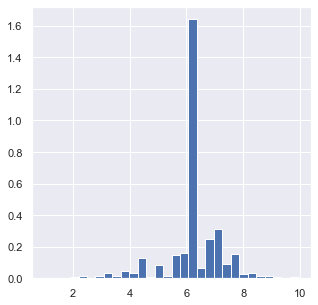

In [40]:
J1 = 30
y, x, _ = plt.hist(horas, bins = J1, density = True)
x = x[1:]
chi_cuadrada('foldcauchy',horas,x,y,J1,0.95) # prueba de chicuadrada 

#### Educación

In [ ]:
educacion = np.array(data['educational-num'])
plt.boxplot(educacion,vert=False)
plt.title('Nivel de Educación')
plt.show()

In [ ]:
educacion = np.sqrt(educacion[educacion>0])
educacion = educacion[~np.isnan(educacion)]
educacion 

In [ ]:
plt.boxplot(educacion,vert=False,  showfliers=False)
plt.title('Nivel de Educación')
plt.show()

In [ ]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)}, 
                    cv=15) # 15-fold cross-validation
grid.fit(educacion[:, None])

In [ ]:
print(grid.best_params_)

In [ ]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.07142857142857142]:
    ax.plot(np.linspace(0.5,4.5,10), kde_sklearn(educacion, np.linspace(0.5,4.5,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(educacion, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

In [ ]:
distribuciones(educacion)

#### Capital Adquirido

In [ ]:
capital = np.array(data['capital-gain'])
plt.boxplot(capital,vert=False)
plt.title('Capital adquirido')
plt.show()

In [ ]:
capital = np.log(capital[capital>0])
capital = capital[~np.isnan(capital)]
capital

In [ ]:
plt.boxplot(capital,vert=False)
plt.title('Capital adquirido')
plt.show()

In [ ]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)},
                    cv=15) # 15-fold cross-validation
grid.fit(capital[:, None])

In [ ]:
print(grid.best_params_)

In [ ]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.07142857142857142]:
    ax.plot(np.linspace(4,12,10), kde_sklearn(capital, np.linspace(4,12,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(capital, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

In [ ]:
distribuciones(capital)

### Visualización de resultados de simulación

### Conclusiones

### Referencias

T.T.B. (2021, 4 agosto). Medical Insurance Premium Prediction. Recuperado 9 de octubre de 2021, de https://www.kaggle.com/tejashvi14/medical-insurance-premium-prediction